In the second step of the pipeline, we first phenotype the cells from the feature table by a sequence of gating on the mean intensity of antibody markers. Next, we use the segmentation mask to assign CellID to each detected MX1 puncta (registration). This mask is of the same shape as the image, with integer value from each voxel labeling the CellID of the segmented cell at that position. These two steps allow us to relate the statistics computed from the spot detection algorithm to the CellID and cell type of the cell that contains the MX1 puncta, enabling further analyses in the pipeline.

In [23]:
import os
import zarr
import tifffile
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import re

warnings.filterwarnings('ignore')

def parse_array_string(arr_str):
    values = [int(val) for val in re.findall(r'\d+', arr_str)]
    return np.array(values)


base_dir = '/n/scratch3/users/z/ziz531/spot_detection_and_analysis/SpotDetection'
im_dir = os.path.join(base_dir, 'MX1.tif') 
feature_table_dir = os.path.join(base_dir, 'F8iia-quantification4.csv') 
gates_dir = os.path.join(base_dir, 'F8iia-gates.csv') 
seg_dir = os.path.join(base_dir, 'cellMask.tif') 


In [2]:
seg = da.from_zarr(zarr.open(tifffile.imread(seg_dir, aszarr=True)))[::2, ::2, ::2].compute()

feature_table = pd.read_csv(feature_table_dir)
unique_cellids_from_sample = np.unique(seg)
feature_table['CellID'] += 1 # Weird but Clarence told me this happens!
feature_table = feature_table.loc[feature_table['CellID'].isin(unique_cellids_from_sample)] # drop these not in this 3D section

gates = pd.read_csv(gates_dir)

We then apply the gates...

In [3]:
gates_dict = dict(zip(gates['markers'], gates['gates']))
gates_dict['MART1'] = 200 # take a smaller threshold to see more tumor cells

gating_params = [(['CD8a'], ['+'], 'CD8+ T cell'),
          (['CD4'], ['+'], 'CD4+ T cell'),
          (['CD11c'], ['+'], 'Monocyte'),
          (['CD11b'], ['+'], 'Neutrophil'),
          (['MART1'], ['+'], 'Tumor'),
          (['FOXP3', 'CD4'], ['+', '+'], 'Treg'),
          (['CD20'], ['+'], 'B cell'),
          (['CD163'], ['+'], 'Macrophage')]

def phenotyping(row):
    for markers, directions, cell_name in gating_params:
        flag=False
        for marker, direction in zip(markers, directions):
            if direction == '+' and row[marker] > gates_dict[marker]:
                pass
            elif direction == '-' and row[marker] > gates_dict[marker]:
                pass
            else:
                flag=True
                break
        if flag is False:
            return cell_name
    return 'Others'

feature_table['Cell type'] = feature_table.apply(phenotyping, axis=1)

To make sure the phenotyping procedure gives sensible results, we will draw out the different cell types in the tissue sample again by a z-projection.

In [4]:
def density_z_projection(seg: np.ndarray, 
                         feature_table: pd.DataFrame, 
                         cell_type: str):
    cellids = feature_table[feature_table['Cell type']==cell_type]['CellID']
    seg_mask = np.isin(seg, cellids)
    return np.sum(seg * seg_mask, axis=0)

tumor_density = density_z_projection(seg, feature_table, 'Tumor')
cd4_density = density_z_projection(seg, feature_table, 'CD4+ T cell')
cd8_density = density_z_projection(seg, feature_table, 'CD8+ T cell')

tumor_counts = np.sum(feature_table['Cell type']=='Tumor')
cd4_counts = np.sum(feature_table['Cell type']=='CD4+ T cell')
cd8_counts = np.sum(feature_table['Cell type']=='CD8+ T cell')

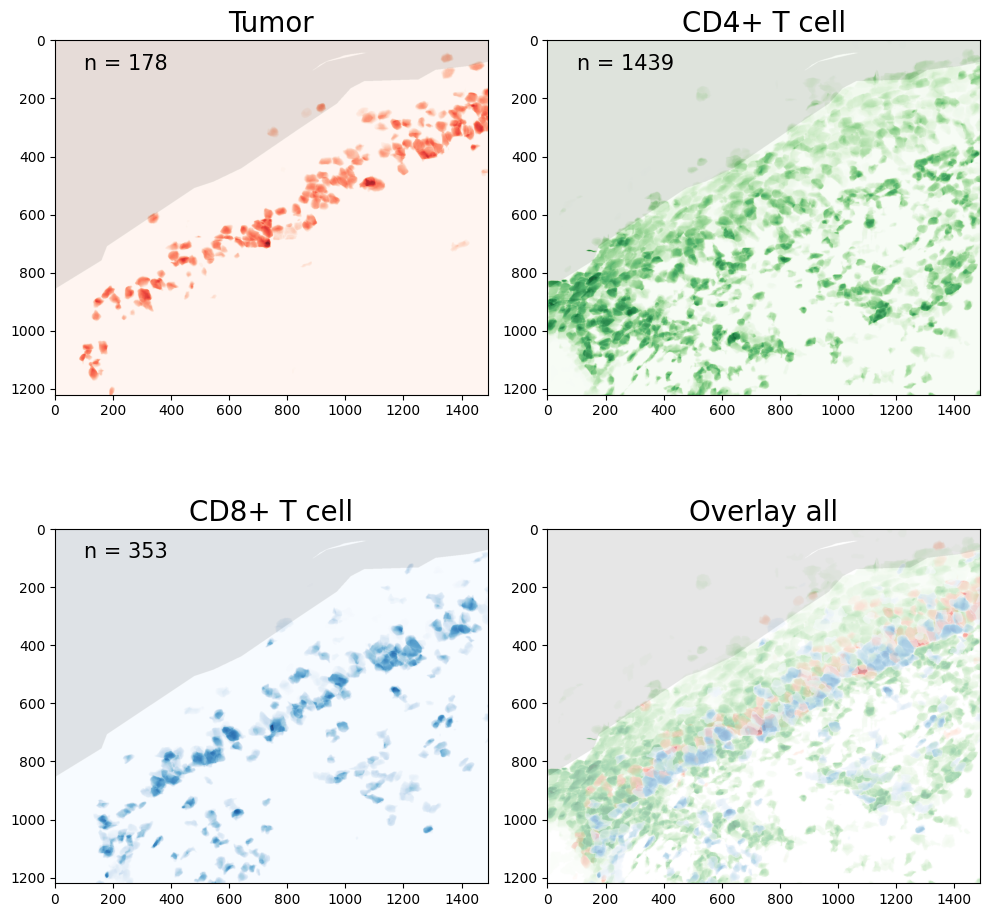

In [5]:
combined_mask = np.load('./combined_mask.npy')

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
quantile_thres = 0.1
axes = axes.ravel()

axes[0].imshow(tumor_density, cmap='Reds')
axes[3].imshow(tumor_density, cmap='Reds', alpha=(tumor_density > np.quantile(tumor_density.ravel(), quantile_thres)).astype(int)*0.5)

axes[1].imshow(cd4_density, cmap='Greens')
axes[3].imshow(cd4_density, cmap='Greens', alpha=(cd4_density > np.quantile(cd4_density.ravel(), quantile_thres)).astype(int)*0.5)

axes[2].imshow(cd8_density, cmap='Blues')
axes[3].imshow(cd8_density, cmap='Blues', alpha=(cd8_density > np.quantile(cd8_density.ravel(), quantile_thres)).astype(int)*0.5)

axes[0].set_title('Tumor', size=20)
axes[0].text(100, 100, f'n = {tumor_counts}', size=15)
axes[0].imshow(~combined_mask, cmap='gray', alpha=0.1)
axes[1].set_title('CD4+ T cell', size=20)
axes[1].text(100, 100, f'n = {cd4_counts}', size=15)
axes[1].imshow(~combined_mask, cmap='gray', alpha=0.1)
axes[2].set_title('CD8+ T cell', size=20)
axes[2].text(100, 100, f'n = {cd8_counts}', size=15)
axes[2].imshow(~combined_mask, cmap='gray', alpha=0.1)
axes[3].set_title('Overlay all', size=20)
axes[3].imshow(~combined_mask, cmap='gray', alpha=0.1)

fig.tight_layout()

Next, we register the MX1 puncta by checking which cells they are in, using the segmentation mask. This will allow us the count the number of MX1 puncta in different cells and record that in the feature table. 

In [6]:
blobs_df = pd.read_csv('./MX1_puncta_stats.csv')
blobs_df['Location'] = blobs_df['Location'].apply(parse_array_string)


In [7]:
blobs_df['CellID'] = blobs_df['Location'].apply(lambda l: seg[*l])
observed_cellids, counts = np.unique(blobs_df['CellID'], return_counts=True)
observed_cellids = list(observed_cellids)

def get_counts(i):
    if i in observed_cellids:
        return counts[observed_cellids.index(i)]
    else:
        return 0
    
feature_table['MX1_counts'] = feature_table['CellID'].apply(lambda i: get_counts(i))

Text(0, 0.5, 'Cell count')

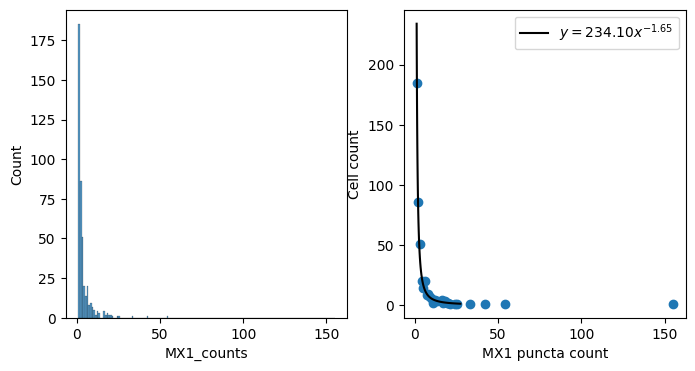

In [8]:
from scipy.stats import linregress

observed_counts, counts_freq = np.unique(counts, return_counts=True)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

### Histogram of freq vs. MX1 count in cells
sns.histplot(feature_table.iloc[1:], x='MX1_counts', 
             binwidth=1, 
             binrange=[np.min(observed_counts), np.max(observed_counts)],
             log_scale=[False, False], ax=axes[0])

### Power law fit to freq vs. MX1 count
logx = np.log(observed_counts[:-5])
logy = np.log(counts_freq)[:-5]
res = linregress(logx, logy)
x = np.exp(np.linspace(0, -res.intercept/res.slope))
y = np.exp(res.slope * np.log(x) + res.intercept)

axes[1].scatter(observed_counts, counts_freq)
axes[1].plot(x, y, c='k', label=f'$y={np.exp(res.intercept):.2f}x^{{{res.slope:.2f}}}$')
axes[1].legend(loc='best')
axes[1].set_xlabel('MX1 puncta count')
axes[1].set_ylabel('Cell count')


There's good agreement between number of MX1 puncta in cells counted using my method versus Clarence's method.

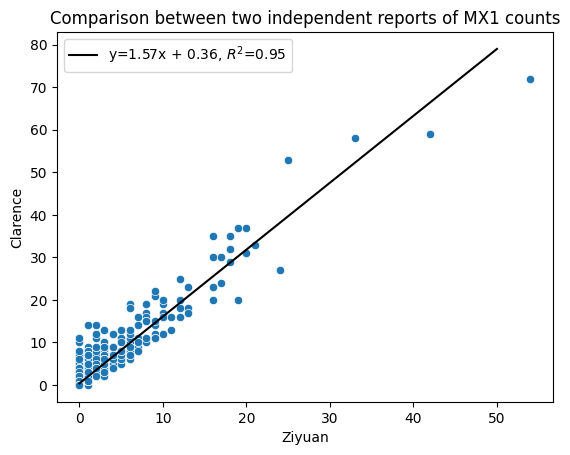

In [9]:
fig, ax = plt.subplots(1, 1)

res = linregress(feature_table['MX1_counts'], feature_table['MX1_SPOTS'])
x = np.linspace(0, 50, 3)
y = res.intercept +  res.slope * x

sns.scatterplot(feature_table, x='MX1_counts', y='MX1_SPOTS', ax=ax)
ax.set_xlabel('Ziyuan')
ax.set_ylabel('Clarence')
ax.plot(x, y, c='k', label=f'y={res.slope:.2f}x + {res.intercept:.2f}, $R^2$={res.rvalue:.2f}')

ax.set_title('Comparison between two independent reports of MX1 counts')
ax.legend(loc='best')

To ensure that we get our registration done right, we can also make box plot to visualize the distribution of the number of MX1 puncta in different cell types. We will see that CD4+ and CD8+ T cells tend to have more MX1 puncta, followed by tumor cells, where as other cell types have almost no MX1 puncta. This appears to make sense given the role of MX1 as a downstream effector of IFNa signaling, which is known to play a role in tumor-immune cell interactions.

sns.boxplot(x='Cell type', y='MX1_counts', data=feature_table, hue='Cell type', whis=(10, 90))
_ = plt.xticks(rotation=45)


It appears that boxplot is really not a good idea for visualizing this data! Try histplot and heatmap...

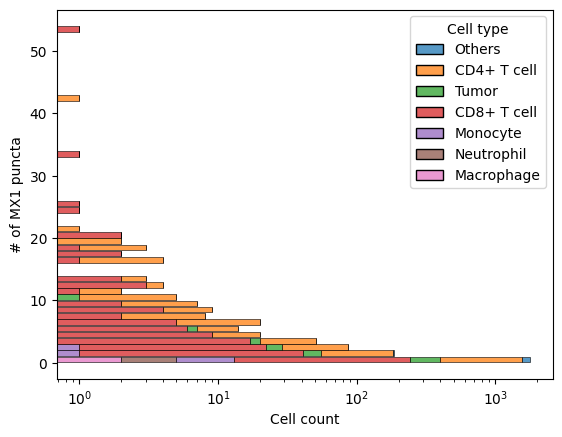

In [11]:
fig, ax = plt.subplots(1, 1)
sns.histplot(data=feature_table, y='MX1_counts', hue='Cell type', 
             multiple='stack', shrink=0.9, binwidth=1, log_scale=[True, False], ax=ax)
_ = ax.set_xlabel("Cell count")
_ = ax.set_ylabel("# of MX1 puncta")

<AxesSubplot:xlabel='MX1 class', ylabel='Cell type'>

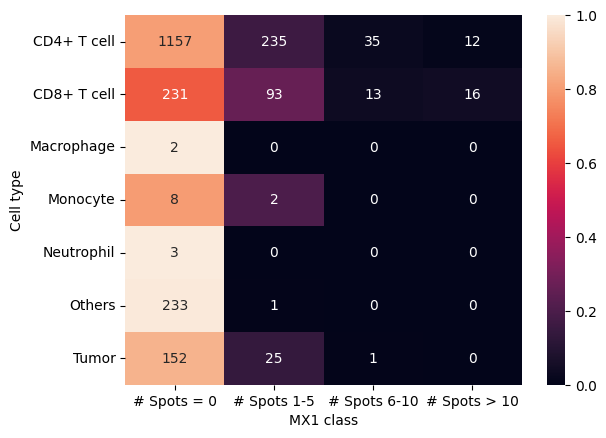

In [12]:
def mx1_classify(count):
    if count == 0:
        return '# Spots = 0'
    elif count >= 1 and count <= 5:
        return '# Spots 1-5'
    elif count >= 5 and count <=10:
        return '# Spots 6-10'
    elif count > 10:
        return '# Spots > 10'
    
feature_table['MX1 class'] = feature_table['MX1_counts'].apply(mx1_classify)

cell_type_spot_counts_crosstab = pd.crosstab(feature_table['Cell type'], feature_table['MX1 class'])
colnames=['# Spots = 0', '# Spots 1-5', '# Spots 6-10', '# Spots > 10']
cell_type_spot_counts_crosstab = cell_type_spot_counts_crosstab[colnames]
cell_type_spot_counts_crosstab_normed = cell_type_spot_counts_crosstab.div(cell_type_spot_counts_crosstab.sum(axis=1), axis=0)
sns.heatmap(cell_type_spot_counts_crosstab_normed, annot=cell_type_spot_counts_crosstab, fmt='')


We will reindex the feature table to use CellID as the index, to facilitate querying the table in later analyses. For each punctum, we also record the cell type for the cell containing it. We further unpack the puncta locations into three columns for flexibility of handling these data later. 

A final interesting visualization here is to see where are the puncta spatially distributed, on the global (respective to the tissue) scale, in the three main cell types.

In [13]:
feature_table = feature_table.set_index('CellID')
def assign_cell_type(row):
    if row['CellID'] == 0:
        return 'None'
    else:
        return feature_table.loc[row['CellID'], 'Cell type']
blobs_df['Cell type'] = blobs_df.apply(assign_cell_type, axis=1)

In [14]:
blobs_df['z'] = [arr[0] for arr in blobs_df['Location']]
blobs_df['x'] = [arr[1] for arr in blobs_df['Location']]
blobs_df['y'] = [arr[2] for arr in blobs_df['Location']]

In [15]:
blobs_df.head()

,Unnamed: 0.1,Unnamed: 0,Location,Size,Background,Amplitude,Center Intensity,Within sample,Gating,CellID,Cell type,z,x,y
0,0,0,"[23, 1114, 180]",1,2114.295662,58775.978687,34346,True,True,1247,CD8+ T cell,23,1114,180
1,1,1,"[48, 1037, 141]",1,1353.050569,45700.596595,33845,True,True,8421,CD4+ T cell,48,1037,141
2,2,2,"[61, 1117, 154]",1,1552.497319,49233.243858,34037,True,True,7683,CD8+ T cell,61,1117,154
3,3,3,"[32, 1117, 201]",1,1653.353944,43893.160420,34085,True,True,1247,CD8+ T cell,32,1117,201
4,4,4,"[42, 1061, 219]",1,1301.338521,46498.850994,33326,True,True,2634,CD8+ T cell,42,1061,219


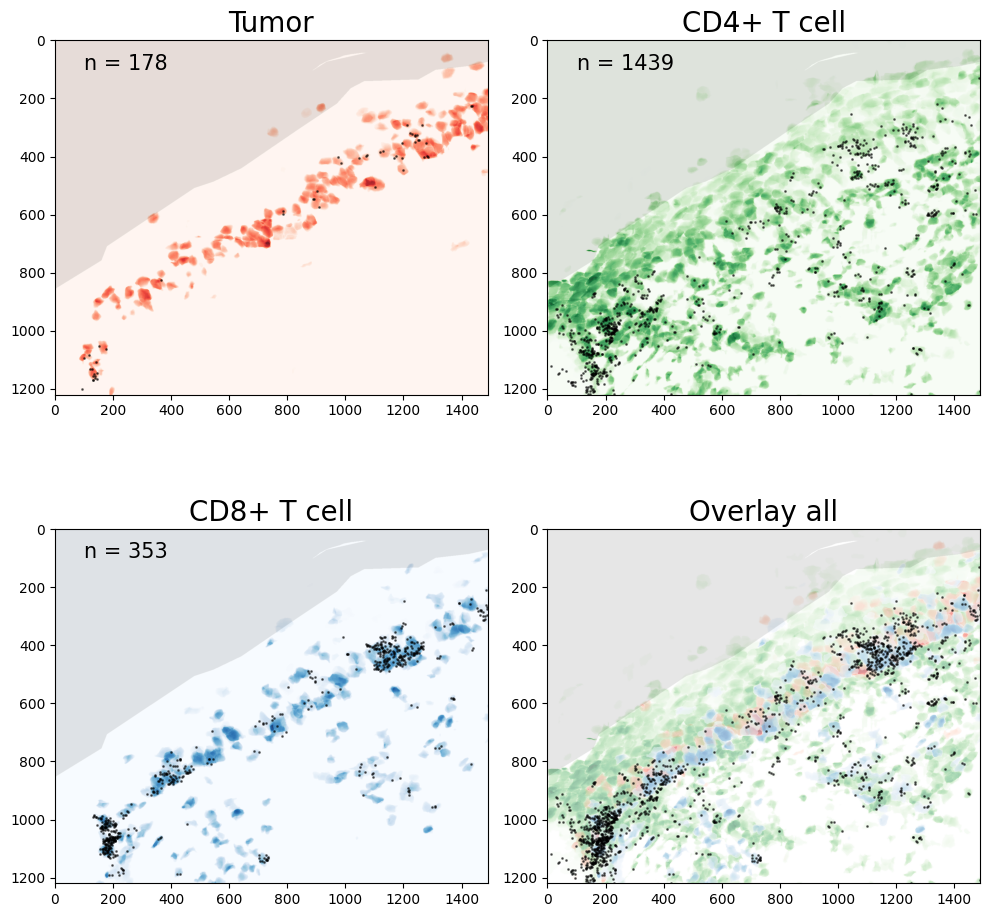

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
quantile_thres = 0.1
axes = axes.ravel()

axes[0].imshow(tumor_density, cmap='Reds')
axes[3].imshow(tumor_density, cmap='Reds', alpha=(tumor_density > np.quantile(tumor_density.ravel(), quantile_thres)).astype(int)*0.5)
blobs_subset = blobs_df[blobs_df['Cell type']=='Tumor']
axes[0].scatter(blobs_subset['y'], blobs_subset['x'], s=1, c='k', alpha=0.5)
axes[3].scatter(blobs_subset['y'], blobs_subset['x'], s=1, c='k', alpha=0.5)


axes[1].imshow(cd4_density, cmap='Greens')
axes[3].imshow(cd4_density, cmap='Greens', alpha=(cd4_density > np.quantile(cd4_density.ravel(), quantile_thres)).astype(int)*0.5)
blobs_subset = blobs_df[blobs_df['Cell type']=='CD4+ T cell']
axes[1].scatter(blobs_subset['y'], blobs_subset['x'], s=1, c='k', alpha=0.5)
axes[3].scatter(blobs_subset['y'], blobs_subset['x'], s=1, c='k', alpha=0.5)

axes[2].imshow(cd8_density, cmap='Blues')
axes[3].imshow(cd8_density, cmap='Blues', alpha=(cd8_density > np.quantile(cd8_density.ravel(), quantile_thres)).astype(int)*0.5)
blobs_subset = blobs_df[blobs_df['Cell type']=='CD8+ T cell']
axes[2].scatter(blobs_subset['y'], blobs_subset['x'], s=1, c='k', alpha=0.5)
axes[3].scatter(blobs_subset['y'], blobs_subset['x'], s=1, c='k', alpha=0.5)


axes[0].set_title('Tumor', size=20)
axes[0].text(100, 100, f'n = {tumor_counts}', size=15)
axes[0].imshow(~combined_mask, cmap='gray', alpha=0.1)
axes[1].set_title('CD4+ T cell', size=20)
axes[1].text(100, 100, f'n = {cd4_counts}', size=15)
axes[1].imshow(~combined_mask, cmap='gray', alpha=0.1)
axes[2].set_title('CD8+ T cell', size=20)
axes[2].text(100, 100, f'n = {cd8_counts}', size=15)
axes[2].imshow(~combined_mask, cmap='gray', alpha=0.1)
axes[3].set_title('Overlay all', size=20)
axes[3].imshow(~combined_mask, cmap='gray', alpha=0.1)

fig.tight_layout()

In [17]:
feature_table.to_csv('./feature_table.csv')
blobs_df.to_csv('./blobs_df.csv')

### Appendix. Co-visualization of cell seg volume and detected MX1 puncta in Napari

In [38]:
import napari

blobs = np.load('./MX1_puncta.npy')
im_raw = zarr.open(tifffile.imread(im_dir, aszarr=True))

def imshow_slices(volume):
    n_slices = volume.shape[0]
    fig, axes = plt.subplots(2, n_slices//2+1, figsize=(2*n_slices//2, 4))
    axes = axes.ravel()
    vmin, vmax = np.min(volume), np.max(volume)
    for i in range(n_slices):
        axes[i].imshow(volume[i, :, :], cmap='gray', vmin=vmin, vmax=vmax)
        axes[i].set_title(f'z-slice {i+1}')
    fig.tight_layout()
    
    return fig, axes

The following code snippet shows how to visualize a single MX1 puncta as a series of images along the z-direction.

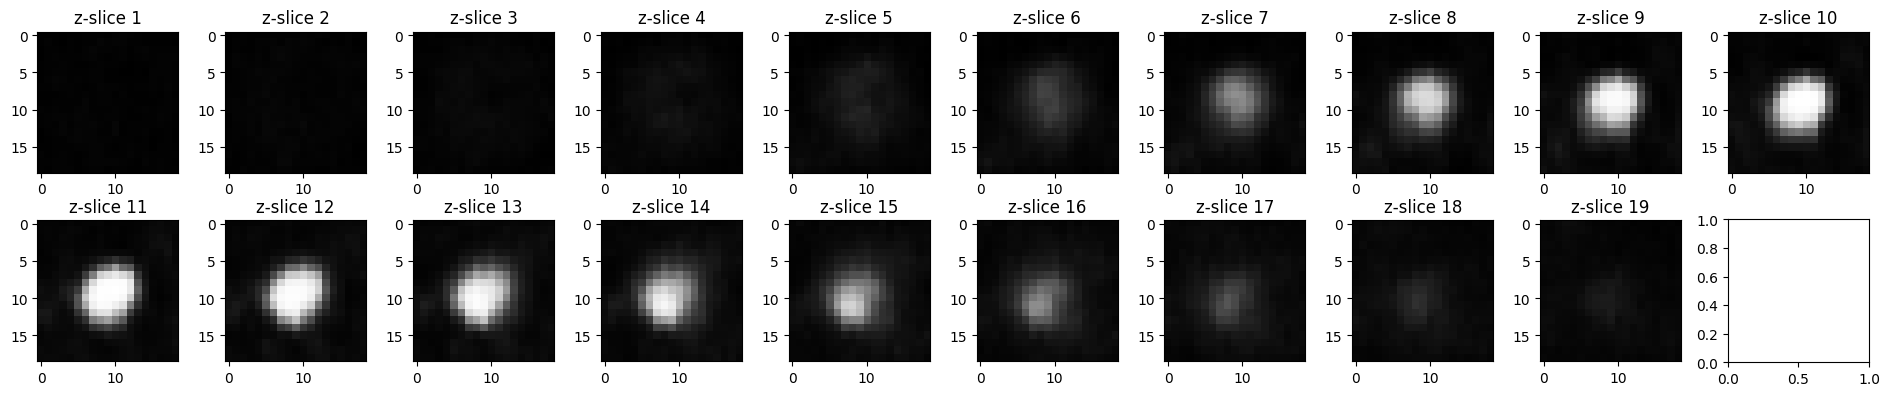

In [31]:
blobs_rescaled = blobs * 2
patch_size = 9
z0, x0, y0, sigma0 = blobs_rescaled[0]
zlow, zhigh = z0-patch_size, z0+patch_size+1
xlow, xhigh = x0-patch_size, x0+patch_size+1
ylow, yhigh = y0-patch_size, y0+patch_size+1
sample_patch = im_raw[zlow:zhigh, xlow:xhigh, ylow:yhigh]

_, _ = imshow_slices(sample_patch)

In [42]:
border_width = 5
cellid = 2
cell_mask = seg==cellid
zids, xids, yids = np.where(cell_mask)
zlim, xlim, ylim = seg.shape
zmin, zmax = max(0, np.min(zids)-border_width), min(np.max(zids)+border_width+1, zlim)
xmin, xmax = max(0, np.min(xids)-border_width), min(np.max(xids)+border_width+1, xlim)
ymin, ymax = max(0, np.min(yids)-border_width), min(np.max(yids)+border_width+1, ylim)
seg_patch = seg[zmin:zmax, xmin:xmax, ymin:ymax]
image_patch = im_raw[zmin:zmax, xmin:xmax, ymin:ymax]
points = blobs[blobs_df['CellID']==cellid, :3] - np.array([zmin, xmin, ymin])

In [ ]:
viewer = napari.Viewer()
viewer.add_image(image_patch, rgb=False, name='MX1 (raw image)')
viewer.add_labels(seg_patch, name='Cell segmentation mask')
viewer.add_points(points, name='Detected MX1 puncta in the center cell')


Available platform plugins are: eglfs, linuxfb, minimal, minimalegl, offscreen, vnc, wayland-egl, wayland, wayland-xcomposite-egl, wayland-xcomposite-glx, webgl, xcb.

